In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model

%matplotlib inline

In [2]:
path = 'data/ml-1m/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [3]:
train.head()

,userId,movieId,rating
0,4783,109,5
1,4071,482,4
2,3133,433,3
3,3216,983,4
4,886,1126,4


In [4]:
train.shape

(800167, 3)

In [5]:
n_users = train.userId.nunique()
n_items = train.movieId.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 6040
Number of items: 3679


In [6]:
max_users = train.userId.max()
max_items = train.movieId.max()
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 6039
Max movie ID: 3705


## Dot product model

In [12]:
# creating book embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 5, name="Book-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         18530       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         30200       User-Input[0][0]                 
______________________________________________________________________________________________

Train on 800167 samples
Epoch 1/5
800167/800167 [==============================] - 48s 61us/sample - loss: 5.1932
Epoch 2/5
800167/800167 [==============================] - 45s 56us/sample - loss: 0.9655
Epoch 3/5
800167/800167 [==============================] - 41s 51us/sample - loss: 0.8663
Epoch 4/5
800167/800167 [==============================] - 35s 43us/sample - loss: 0.8540
Epoch 5/5
800167/800167 [==============================] - 31s 39us/sample - loss: 0.8477


Text(0, 0.5, 'Training Error')

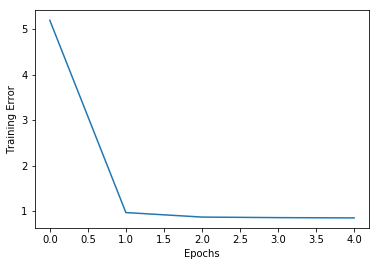

In [13]:
# model = load_model('regression_model.h5')

history = model.fit([train.userId, train.movieId], train.rating, batch_size=64, epochs=5, verbose=1)
model.save('regression_model.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [14]:
model.evaluate([test.userId, test.movieId], test.rating, batch_size=1028)

200042/200042 [==============================] - 0s 2us/sample - loss: 0.8529


0.8529435986299571

In [15]:
predictions = model.predict([test.userId.head(10), test.movieId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.8854806] 4
[4.2170343] 4
[3.0050156] 2
[3.6940308] 4
[3.2575219] 4
[4.155516] 3
[3.2925386] 1
[3.5954118] 4
[3.5600216] 4
[4.0090647] 4


[None, None, None, None, None, None, None, None, None, None]

## Neural network model

In [16]:
from tensorflow.keras import backend as K

def squeeze(x):
    return K.sigmoid(x) * (5 - 1) + 1

In [17]:
# creating book embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 5, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([item_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
d1 = Dropout(.5)(fc1)
fc2 = Dense(32, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
out = Dense(1, activation=squeeze)(d2)

# Create model and compile it
model2 = Model([user_input, item_input], out)
model2.compile('adam', 'mean_squared_error')
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         18530       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         30200       User-Input[0][0]                 
____________________________________________________________________________________________

Train on 800167 samples
Epoch 1/10
800167/800167 [==============================] - 37s 47us/sample - loss: 0.8830
Epoch 2/10
800167/800167 [==============================] - 34s 42us/sample - loss: 0.8218
Epoch 3/10
800167/800167 [==============================] - 33s 42us/sample - loss: 0.8040
Epoch 4/10
800167/800167 [==============================] - 29s 37us/sample - loss: 0.7872
Epoch 5/10
800167/800167 [==============================] - 28s 35us/sample - loss: 0.7726
Epoch 6/10
800167/800167 [==============================] - 28s 36us/sample - loss: 0.7639
Epoch 7/10
800167/800167 [==============================] - 28s 36us/sample - loss: 0.7583
Epoch 8/10
800167/800167 [==============================] - 28s 35us/sample - loss: 0.7531
Epoch 9/10
800167/800167 [==============================] - 28s 35us/sample - loss: 0.7498
Epoch 10/10
800167/800167 [==============================] - 28s 35us/sample - loss: 0.7463


Text(0, 0.5, 'Training Error')

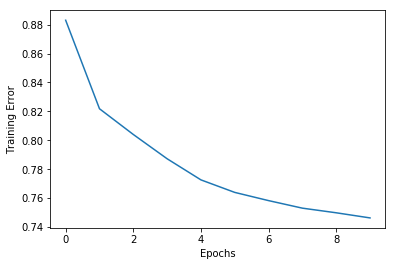

In [18]:
# model2 = load_model('regression_model2.h5')

history = model2.fit([train.userId, train.movieId], train.rating, batch_size=128, epochs=10)
model2.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [19]:
model2.evaluate([test.userId, test.movieId], test.rating, batch_size=1028)

200042/200042 [==============================] - 1s 3us/sample - loss: 0.7747


0.7747212188930439

In [20]:
np.sqrt(0.7747)

0.8801704380402696

In [20]:
predictions = model2.predict([test.userId.head(10), test.movieId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.9160562] 4
[4.1927013] 4
[3.221256] 2
[3.6316247] 4
[3.5453532] 4
[3.9005413] 3
[3.500532] 1
[3.7732334] 4
[3.806945] 4
[3.767392] 4


[None, None, None, None, None, None, None, None, None, None]

## Visualise embeddings

In [22]:
# Extract embeddings
item_em = model2.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [23]:
item_em_weights[:5]

array([[-0.5601345 , -0.38733152,  0.43833888,  0.17569712,  0.15098982],
       [ 0.05883945, -0.05871598,  0.06890205, -0.20075642,  0.24317768],
       [-0.30049703, -0.40940586,  0.41632253,  0.15061784, -0.29987153],
       [-0.14889514, -0.13104902,  0.2260833 , -0.3400312 , -0.54028535],
       [-0.2205497 , -0.3162046 ,  0.21768332, -0.1433742 , -0.13120154]],
      dtype=float32)

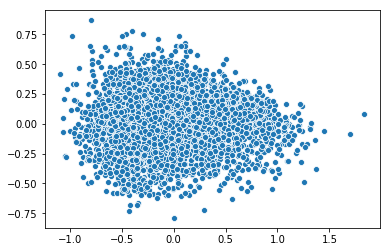

In [24]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [25]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

0.9999999

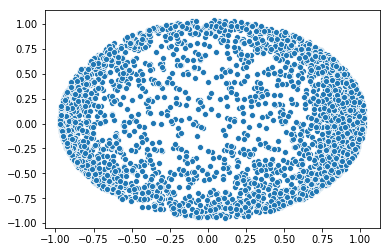

In [26]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.005s...
[t-SNE] Computed neighbors for 10001 samples in 0.582s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.020262
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.121651
[t-SNE] KL

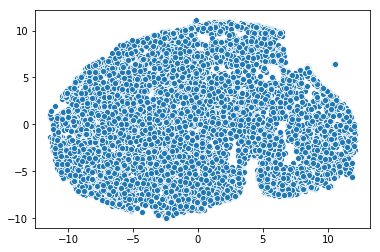

In [28]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [27]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.movieId)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [28]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [29]:
predictions = model2.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

array([ 167, 3410,   23,   44,  127], dtype=int64)

In [30]:
# print predicted scores
predictions[recommended_movie_ids]

array([4.735052 , 4.713495 , 4.7017894, 4.6811566, 4.672861 ],
      dtype=float32)

In [31]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,40,Toy Story (1995),Animation|Children's|Comedy
1,573,Jumanji (1995),Adventure|Children's|Fantasy
2,1333,Grumpier Old Men (1995),Comedy|Romance
3,450,Waiting to Exhale (1995),Comedy|Drama
4,1334,Father of the Bride Part II (1995),Comedy


In [33]:
movies[movies['movieId'].isin(recommended_movie_ids)]

,movieId,title,genres
253,44,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
309,167,"Shawshank Redemption, The (1994)",Drama
513,23,Schindler's List (1993),Drama|War
1108,127,Raiders of the Lost Ark (1981),Action|Adventure
2900,3410,Miss Julie (1999),Drama
